In [1]:
import numpy
import qubit_matmul
import scipy.sparse
from matplotlib import pyplot
import os
import shadow_reconstruction
import sys

In [2]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])
sn = numpy.array([
    [0.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szzzz = numpy.kron(szz,szz)
snn = numpy.kron(sn,sn)

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_zzzz(i,j,k,l):
    return qubit_matmul.TensorMatf64([i,j,k,l], szzzz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

In [3]:
def make_ladder_ham(l,mu=0.0, v=1.0, trung=0.0, trail=0.0, periodic=False):
    n = (mu * sn).flatten().astype(numpy.float64)
    nn = (v * numpy.kron(sn,sn)).flatten().astype(numpy.float64)
    rung_hop = ((trung * spm) + numpy.conj(trung * smp)).flatten().astype(numpy.float64)
    rail_hop = ((trail * spm) + numpy.conj(trail * smp)).flatten().astype(numpy.float64)
    
    terms = []
    
    for i in range(l//2):
        a = 2*i
        b = 2*i + 1
        terms.extend([
            qubit_matmul.TensorMatf64([a], n),
            qubit_matmul.TensorMatf64([b], n),
            qubit_matmul.TensorMatf64([a,b], rung_hop),
            qubit_matmul.TensorMatf64([a,b], nn)
        ])
        
        aa = a + 2
        bb = b + 2
        if periodic:
            aa = aa % l
            bb = bb % l
        
        if aa < l and bb < l:
            terms.extend([
                # Hopping upper and lower
                qubit_matmul.TensorMatf64([a,aa], rail_hop),
                qubit_matmul.TensorMatf64([b,bb], rail_hop),
            ])
            
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

In [4]:
def make_gs(l,nsector=2,k=4,**kwargs):
    ham = make_ladder_ham(l,**kwargs)
    
    print("Making states...", end='', flush=True)
    num_sector_states = numpy.array(shadow_reconstruction.number_sector_states(l, nsector))
    print("done", flush=True)
    
    print("Making sparse hamiltonian...", end='', flush=True)
    ham = ham.get_sparse(l, restrict_rows=num_sector_states, reindex=True)
    print("done", flush=True)
    print(ham.shape)
    
    print("Diagonalizing hamiltonian...", end='', flush=True)
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(ham, k=k, which='SA')
    print("done", flush=True)
    
    eigvec = eigvecs[:,0]
    return eigvec, num_sector_states
    
def make_data(l,nsector=2,hermitian=False,k=4,**kwargs):
    gs,num_sector_states = make_gs(l, nsector=nsector,k=k,**kwargs)
    
    print("Making ZZ", flush=True)
    zz_corrs = []
    zz_xcorr = numpy.arange(2,l,2)
    for r in zz_xcorr:
        corr_check = make_zz(0,r).get_sparse(l, restrict_rows=num_sector_states,reindex=True)
        ground_truth = numpy.conj(gs.T) @ (corr_check @ gs)
        zz_corrs.append(ground_truth)
    zz_data = (zz_xcorr, numpy.array(zz_corrs))
    
    print("Making ZZZZ", flush=True)
    zzzz_corrs = []
    zzzz_xcorr = numpy.arange(2,l,2)
    for r in zzzz_xcorr:
        corr_check = make_zzzz(0,1,r,r+1).get_sparse(l, restrict_rows=num_sector_states,reindex=True)
        ground_truth = numpy.conj(gs.T) @ (corr_check @ gs)
        zzzz_corrs.append(ground_truth)
    zzzz_data = (zzzz_xcorr, numpy.array(zzzz_corrs))

    print("Making PM", flush=True)
    corrs = []
    xcorr = numpy.arange(2,l,2)
    for r in xcorr:
        corr_check = make_pm(0,r).get_sparse(l, restrict_rows=num_sector_states,reindex=True)
        if hermitian:
            corr_check = corr_check + corr_check.T
        ground_truth = numpy.conj(gs.T) @ (corr_check @ gs)
        corrs.append(ground_truth)
    pm_data = (xcorr, numpy.array(corrs))
        
    print("Making PPMM", flush=True)
    pair_corrs = []
    xpaircorr = numpy.arange(2,l,2)
    for r in xpaircorr:
        corr_check = make_pmpm(0,r,1,r+1).get_sparse(l, restrict_rows=num_sector_states,reindex=True)
        if hermitian:
            corr_check = corr_check + corr_check.T
        ground_truth = numpy.conj(gs.T) @ (corr_check @ gs)
        pair_corrs.append(ground_truth)
    ppmm_data = (xpaircorr, numpy.array(pair_corrs))
    
    return gs, zz_data, zzzz_data, pm_data, ppmm_data

In [69]:
l = 50
nsector = 2
gs, states= make_gs(l,nsector=nsector,v=-3.0,trail=-0.5,trung=-0.1,periodic=False)
gs = gs.astype(numpy.complex128)
states = states.astype(numpy.uint64)

Making states...done
Making sparse hamiltonian...done
(1225, 1225)
Diagonalizing hamiltonian...done


In [70]:
rho = shadow_reconstruction.DensityMatrix.new_pure_sparse_indices(l, states, gs)
exp = shadow_reconstruction.Experiment(l)
samples = exp.sample(rho, 800_000)

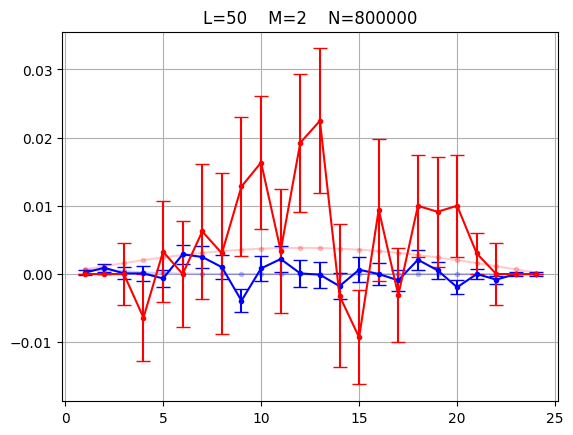

In [76]:
recon = shadow_reconstruction.Reconstruction()

dat = []
for i in range(l//2-1):
    dat.append(rho.expectation_string('+I' + 'II'*(i) + '-I'))
dat = numpy.array(dat)
pyplot.plot(1+numpy.arange(l//2-1),dat.real, '.-', c='b', alpha=0.2)

mu_dat = []
sigma_dat = []
for i in range(l//2-1):
    string = '+I' + 'II'*(i) + '-I' + 'II'*((l - 2*i - 4)//2)
    vs = recon.estimate_string_for_each_sample(string, samples).real
    mu_dat.append(vs.real.mean())
    sigma_dat.append(vs.real.std()/numpy.sqrt(len(vs)))
mu_dat = numpy.array(mu_dat)
sigma_dat = numpy.array(sigma_dat)
pyplot.errorbar(1+numpy.arange(l//2-1),mu_dat,yerr=sigma_dat, marker='.', c='b', capsize=5)


dat = []
for i in range(l//2-1):
    dat.append(rho.expectation_string('++' + 'II'*(i) + '--'))
dat = numpy.array(dat)
pyplot.plot(1+numpy.arange(l//2-1), dat.real, '.-', c='r', alpha=0.2)

mu_dat = []
sigma_dat = []
for i in range(l//2-1):
    string = '++' + 'II'*(i) + '--' + 'II'*((l - 2*i - 4)//2)
    vs = recon.estimate_string_for_each_sample(string, samples).real
    mu_dat.append(vs.real.mean())
    sigma_dat.append(vs.real.std()/numpy.sqrt(len(vs)))
mu_dat = numpy.array(mu_dat)
sigma_dat = numpy.array(sigma_dat)
pyplot.errorbar(1+numpy.arange(l//2-1),mu_dat,yerr=sigma_dat, marker='.', c='r', capsize=5)

pyplot.grid()
pyplot.title(f'L={l}    M={nsector}    N={samples.num_samples()}')
pyplot.savefig('/tmp/recon.jpeg')
pyplot.show()

In [43]:
l = 62
nsector = 2
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,nsector=nsector,v=-3.0,trail=-0.5,trung=-0.1,periodic=False,hermitian=False)

Making states...done
Making sparse hamiltonian...done
(1891, 1891)
Diagonalizing hamiltonian...done
Making ZZ
Making ZZZZ
Making PM
Making PPMM


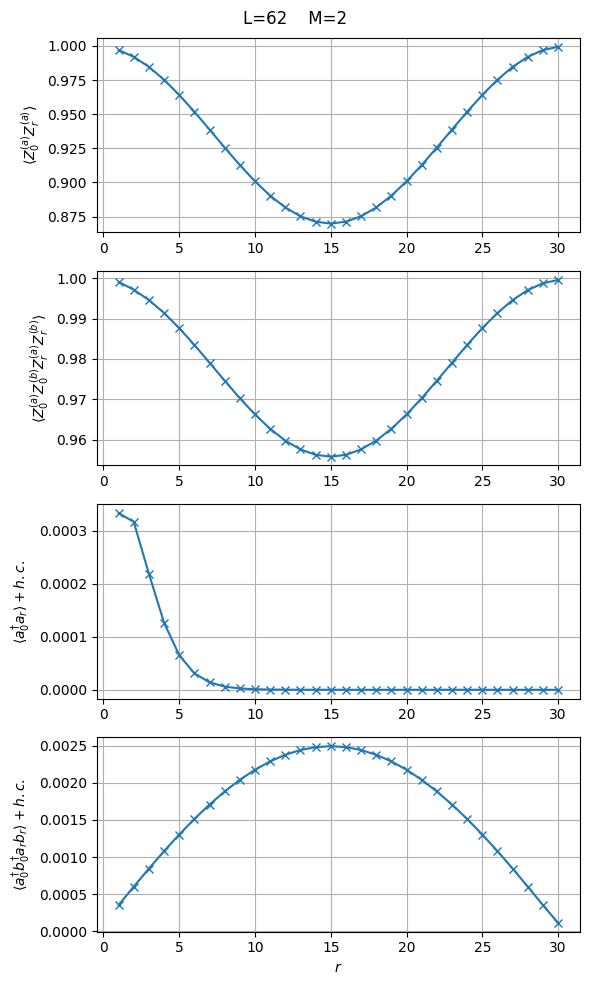

In [44]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

fig.suptitle(f"L={l}    M={nsector}")

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')


fig.tight_layout()
pyplot.savefig('/tmp/plots1.jpeg')
pyplot.show()

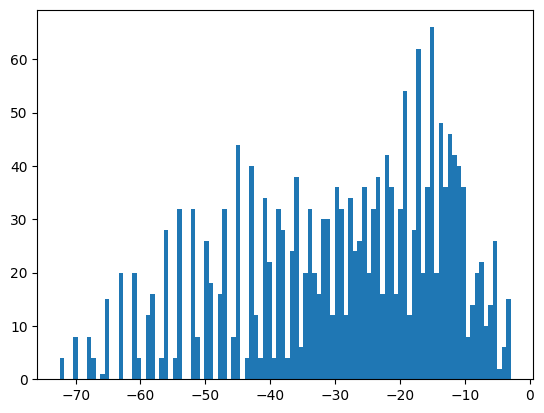

In [50]:
pyplot.hist(numpy.log(abs(gs)**2), bins=100)
pyplot.show()

In [51]:
l = 50
nsector = 4
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,nsector=nsector,v=-3.0,trail=-0.5,trung=-0.1,periodic=False,hermitian=False)

Making states...done
Making sparse hamiltonian...done
(230300, 230300)
Diagonalizing hamiltonian...done
Making ZZ
Making ZZZZ
Making PM
Making PPMM


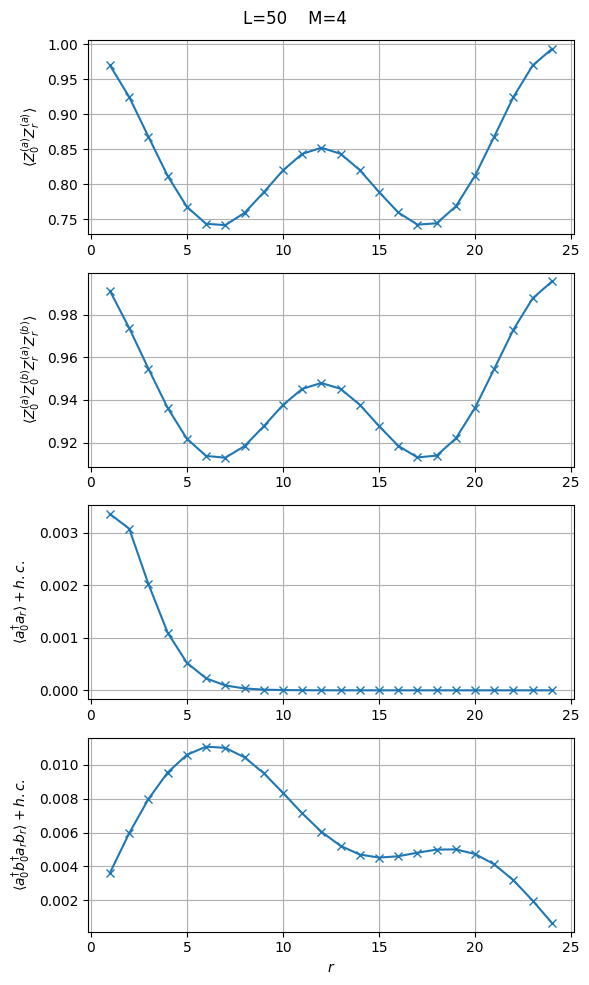

In [52]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

fig.suptitle(f"L={l}    M={nsector}")

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')


fig.tight_layout()
pyplot.savefig('/tmp/plots2.jpeg')
pyplot.show()

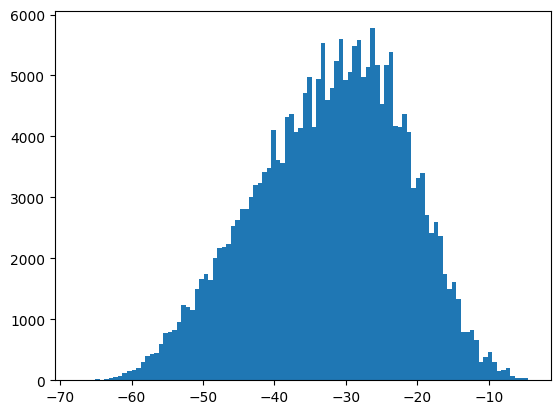

In [53]:
pyplot.hist(numpy.log(abs(gs)**2), bins=100)
pyplot.show()

In [54]:
l = 30
nsector = 6
gs, (xz, zz), (xzz, zzzz), (xpm, pm), (xppmm, ppmm) = make_data(l,nsector=nsector,v=-3.0,trail=-0.5,trung=-0.1,periodic=False,hermitian=False)

Making states...done
Making sparse hamiltonian...done
(593775, 593775)
Diagonalizing hamiltonian...done
Making ZZ
Making ZZZZ
Making PM
Making PPMM


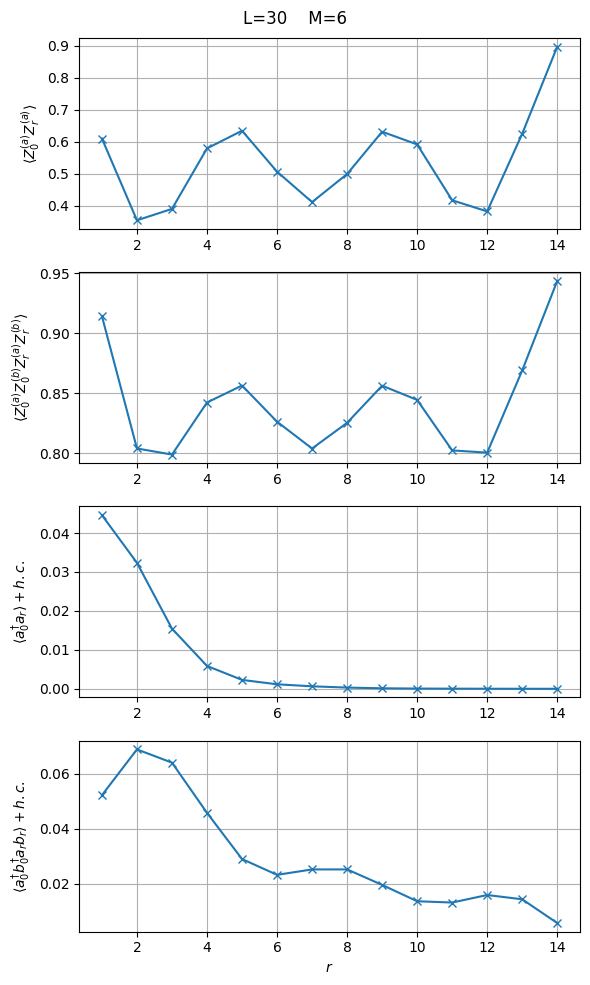

In [55]:
fig, axs = pyplot.subplots(4, figsize=(6,10))

fig.suptitle(f"L={l}    M={nsector}")

axs[0].plot(xz/2, zz.real,'x-')
axs[0].grid()
axs[0].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(a)}_r \rangle$')

axs[1].plot(xzz/2, zzzz.real,'x-')
axs[1].grid()
axs[1].set_ylabel(r'$\langle Z^{(a)}_0 Z^{(b)}_0 Z^{(a)}_r Z^{(b)}_r \rangle$')

axs[2].plot(xpm/2, pm.real,'x-')
axs[2].grid()
axs[2].set_ylabel(r'$\langle a_0^{\dagger} a_r \rangle + h.c.$')

axs[3].plot(xppmm/2, ppmm.real,'x-')
axs[3].grid()
axs[3].set_ylabel(r'$\langle a_0^{\dagger}b_0^{\dagger} a_r b_r \rangle + h.c.$')
axs[3].set_xlabel(r'$r$')


fig.tight_layout()
pyplot.savefig('/tmp/plots3.jpeg')
pyplot.show()

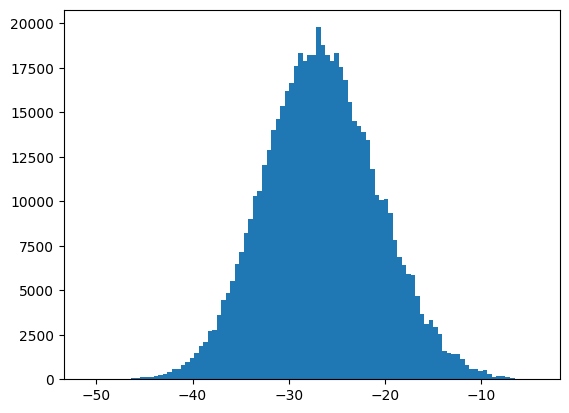

In [56]:
pyplot.hist(numpy.log(abs(gs)**2), bins=100)
pyplot.show()